In [ ]:
#tripathi buffer - demonstrating reconstruction without image tampering, image integrity included
#using SHA and Permuted Congruential Generator for mapping

In [ ]:
from PIL import Image
import random
import io
from numpy.random import default_rng
import hashlib
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
class TripathiBuffer:
    def __init__(self):
        pass

    @staticmethod
    def get_seed_from_string(s):
        hash_digest = hashlib.sha256(s.encode()).hexdigest() #gives us hex digest
        return int(hash_digest, 16) % (2**32) #reduces to 32 bits
    @staticmethod
    def generate_noise_from_seed(seed, shape):
        rng = default_rng(seed) # uses PCG64 by default (oneills permutation something)
        return rng.integers(0, 256, size=shape, dtype=np.uint8) #use rng (seeded) to create fixed output between 0-256 and shape is given same as input image

    @staticmethod
    def sha256_hash_image(image, user_string):
        image_bytes = image.tobytes()
        hash_digest = hashlib.sha256(image_bytes+user_string.encode()).hexdigest()
        return hash_digest

    @staticmethod
    def pick_random_pixels(img, num_pixels=4):
        height, width, i = img.shape
        i = None
        random_pixels = []
        for _ in range(num_pixels):
            x = random.randint(0, width - 1)
            y = random.randint(0, height - 1)
            pixel_value = img[y, x]
            random_pixels.append([x,y,pixel_value])
        return random_pixels

    def encrypt(self):
        uploaded = files.upload()
        self.image =  np.array(Image.open(list(uploaded.keys())[0]).convert("RGB"), dtype=np.uint8)
        self.shape = self.image.shape
        shape = self.shape
        user_string = input("Enter your secret key: ")
        composite = f"{user_string}_F_P{shape[0]}x{shape[1]}x{shape[2]}"
        seed = self.get_seed_from_string(composite)
        composite = f"{shape[0]}x{shape[1]}x{shape[2]}"
        noise = self.generate_noise_from_seed(seed, shape)
        noisy_image = (self.image.astype(int) + noise.astype(int)) % 256
        noisy_image = noisy_image.astype(np.uint8)
        secret_pixels = self.pick_random_pixels(noisy_image)
        composite += 'E_E'
        for s in secret_pixels:
            composite += f"_|{s[0]}|{s[1]}|{s[2][0]}|{s[2][1]}|{s[2][2]}"
        image_hash = self.sha256_hash_image(noisy_image, user_string)
        composite += f"_HASH_{image_hash}"
        return {'img': noisy_image, 'tbuffer': composite}

    def decrypt(self, encrypted_image, key):
        keyhash = key.split('_HASH_')[1]
        shared = input('enter the key to verify and decrypt:')
        image_hash = self.sha256_hash_image(encrypted_image, shared)
        if keyhash != image_hash:
            print('hash integrity verification failed!')
            return None
        else:
            print('hash integrity verified!')
        keyshape = key.split('E_E')[0]
        shape_2 = encrypted_image.shape
        if keyshape != f"{shape_2[0]}x{shape_2[1]}x{shape_2[2]}":
            print('shape of image different from key\nshape integrity verification failed!')
            return None
        else:
            print('shape integrity verified!')
        composite = f"{shared}_F_P{shape_2[0]}x{shape_2[1]}x{shape_2[2]}"
        seed = self.get_seed_from_string(composite)
        noise_2 = self.generate_noise_from_seed(seed, shape_2)
        recovered = (encrypted_image.astype(int) - noise_2.astype(int)) % 256
        recovered = recovered.astype(np.uint8)
        return recovered


In [ ]:
#SENDER ACTIONS

In [ ]:
encryptor_obj = TripathiBuffer()

In [ ]:
encrypted = encryptor_obj.encrypt()

Saving chashme badoor 2.png to chashme badoor 2 (1).png
Enter your secret key: secret1


In [ ]:
private_key = encrypted['tbuffer']
enc_img = encrypted['img']

In [ ]:
private_key #THIS VARIABLE TO BE USED TO CONFIRM INTEGRITY OF IMAGE, TO BE SHARED WITH ONLY INTENDED USER

'857x642x3E_E_|424|838|153|26|14_|368|286|215|52|100_|190|143|247|42|241_|159|425|83|91|76_HASH_fdab55f93a5b7156a6e15eea200c441cb9130828a2bacf694055a7191ac5b0d6'

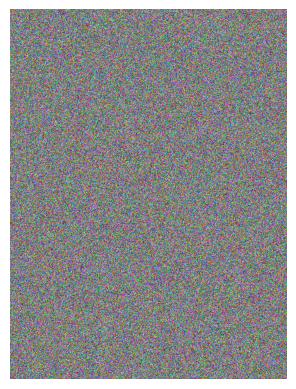

In [ ]:
plt.imshow(enc_img)
plt.axis('off')
plt.show()

In [ ]:
#DELIBERATE TESTING WITH INCORRECT KEY
hacker_obj = TripathiBuffer()
decrypted = hacker_obj.decrypt(enc_img, private_key)

enter the key to verify and decrypt:secret2
hash integrity verification failed!


In [ ]:
#RECIEVER ACTION

In [ ]:
reciever_obj = TripathiBuffer()
decrypted = reciever_obj.decrypt(enc_img, private_key)

enter the key to verify and decrypt:secret1
hash integrity verified!
shape integrity verified!


In [ ]:
difference = (decrypted.astype(int) - encryptor_obj.image.astype(int)) % 256
print("Recovery successful:", np.all(difference == 0))

Recovery successful: True


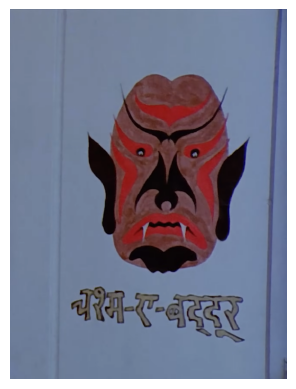

In [ ]:
plt.imshow(decrypted)
plt.axis('off')
plt.show()